## Capstone Project: Image Classification Using Artificial and Convolutional Neural Networks

In [1]:
# Importing modules
import keras
import tensorflow as tf 
import os
import pickle

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

print (tf.__version__) # to check `tf` version
physical_devices = tf.config.list_physical_devices('GPU') # to check whether it's using GPU or not
print("Num GPUs:", len(physical_devices))

2.7.0
Num GPUs: 0


Having the [background information](https://github.com/sthirpa/Data_Scince_Immersive-at-General-Assembly-/blob/Hirpa/IntroductoryNotes.ipynb) on building neural networks from scratch to have multilayer NNs, I'm going to load and preprocess the `CIFAR-10` dataset. from the [its official website](https://www.cs.toronto.edu/~kriz/cifar.html), CIFAR-10 has multiple versions of the dataset. I chose the [python version](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) and then unpacked the file on my local machine.


## Loading Preprocessing the dataset

The files inside the `.tar.gz` file are:

```
|
|- cifar-10-batches-py
    |- batches.meta
    |- data_batch_1
    |- data_batch_2
    |- data_batch_3
    |- data_batch_4
    |- data_batch_5
    |- readme.html
    |- test_batch

```

In [2]:
# unpickling just the firts batch
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

In [3]:
file = r'cifar-10-batches-py/data_batch_1'
data_batch_1 = unpickle(file)

In [4]:
# check data type
type(data_batch_1)

dict

In [5]:
# Let’s look what are the keys in the dictionary
print(data_batch_1.keys())

dict_keys(['batch_label', 'labels', 'data', 'filenames'])


* There are four keys: `batch_lebel`, `labels`, `data` and `filenames`. Let’s look these four levels’ class types. 


In [6]:
for item in data_batch_1:
    print(item, type(data_batch_1[item]))

batch_label <class 'str'>
labels <class 'list'>
data <class 'numpy.ndarray'>
filenames <class 'list'>


In [7]:
# checking the label lists
print("Labels:", set(data_batch_1['labels']))


Labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [8]:
label = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [9]:
# load the 'batches.meta' to check label names
meta_file = r'cifar-10-batches-py/batches.meta'
meta_data = unpickle(meta_file)

In [10]:
print(type(meta_data))
print(meta_data.keys())

<class 'dict'>
dict_keys(['num_cases_per_batch', 'label_names', 'num_vis'])


In [11]:
# get the label names
print("Label Names:", meta_data['label_names'] )

Label Names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [12]:
# assign the class names to a variable
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

The 10 classes of the `CIFAR-10` dataset is summarized as shown in the table below.


|label|Description|
|---|---|
|0|airplane|
|1 |automobile|
|2|bird|
|3|cat|
|4|deer|
|5|dog|
|6|frog|
|7|horse|
|8|ship|
|9|truck|


Text(0.5, 1.0, 'frog')

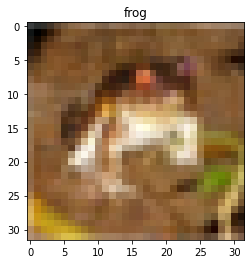

In [13]:
# display sample image from data_batch_1
# label names
label_name = meta_data['label_names']
# take first image
image = data_batch_1['data'][0]
# take first image label index
label = data_batch_1['labels'][0]
# Reshape the image
image = image.reshape(3,32,32)
# Transpose the image
image = image.transpose(1,2,0)
# Display the image
plt.imshow(image)
plt.title(label_name[label])

In [14]:
# checking the `numpy.ndarray` data
X_train1 = data_batch_1['data']
X_train1


array([[ 59,  43,  50, ..., 140,  84,  72],
       [154, 126, 105, ..., 139, 142, 144],
       [255, 253, 253, ...,  83,  83,  84],
       ...,
       [ 71,  60,  74, ...,  68,  69,  68],
       [250, 254, 211, ..., 215, 255, 254],
       [ 62,  61,  60, ..., 130, 130, 131]], dtype=uint8)

* **So, our image data is a numpy ndarray for each batch.**

In [15]:
X_train1.shape

(10000, 3072)

The whole data_batch_1 has 10,000 images. And each image is a 1-D array having 3,072 entries. <br>
   * First 1024 entries for Red, <br>
   * the next 1024 entries for Green and <br>
   * last 1024 entries for Blue channels. <br>
   
Because, `1024 X 1024 X 1024 = 3072` for the `RGB` channels; where `1024 = 32X32`, respectively. <br>
To visualise the images we have to change the shape of image as (32,32,3).



## Reshape And Transpose a Single Image

* First we reshape the image/ array into (3,32,32) using `image.reshape(3,32,32)`. <br>
(32,32) for 32x32 =1024 entries and 3 for RGB channels.

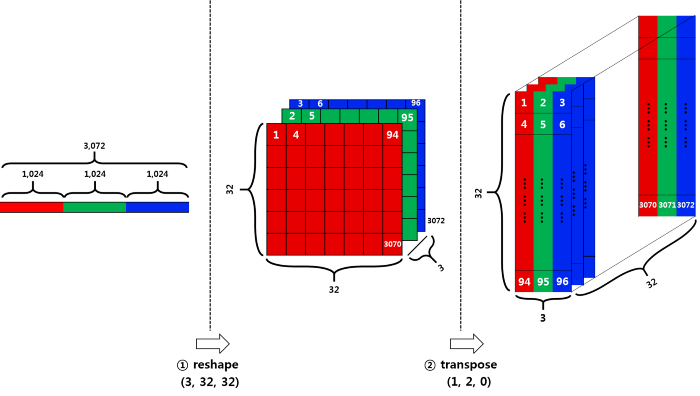

Fig. Reshape and Transpose of an image ([source](https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c))

In [16]:
image = data_batch_1['data'][0]
image = image.reshape(3,32,32)
print('Initial image shape: ',image.shape)

Initial image shape:  (3, 32, 32)


* Next we transpose the reshaped image to get the image of shape (32,32,3). <br>
We use `image.transpose(1,2,0)`.

In [17]:
image = image.transpose(1,2,0)
print('Reshaped image: ',image.shape)

Reshaped image:  (32, 32, 3)


Now, our image in the right format for display using [Matplotlib](https://matplotlib.org/).

In [18]:
# helper function to concatenate all the 5 batches, 

img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 3)
def load_pickle(f):
    return  pickle.load(f, encoding='latin1')

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000,3072)
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar-10-batches-py/'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # cast ast 'float32'
    x_train = X_train.astype('float32')
    x_test = X_test.astype('float32')

    # normalize pixels
    x_train /= 255
    x_test /= 255

    return x_train, y_train, X_val, y_val, x_test, y_test


# Invoke the above function to get our data.
x_train, y_train, x_val, y_valid, x_test, y_test = get_CIFAR10_data()


print('Train data initial shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data initial shape: ', x_val.shape)
print('Validation labels shape: ', y_valid.shape)
print('Test data initial shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)
# https://stackoverflow.com/questions/37512290/reading-cifar10-dataset-in-batches

Train data initial shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data initial shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data initial shape:  (10000, 3072)
Test labels shape:  (10000,)


* Here, we need to transform the whole dataset into a `32X32X3` format so that, `matplotlib` can help us visualize sample pictures.

## Reshape And Transpose CIFAR-10 Dataset

In [19]:
x_train.shape

(49000, 3072)

In [20]:
X_train = x_train.reshape(len(x_train), 3, 32, 32)
X_train = X_train.transpose(0,2,3,1)
print('X_train shape: ',X_train.shape )

X_train shape:  (49000, 32, 32, 3)


* Here `X_train` is the desired format. I am going to do the same for my `X_val`.

* Here `X_train` is the desired format. I am going to do the same for my `X_val`, and `X_test`.

In [21]:
X_valid = x_val.reshape(len(x_val), 3, 32, 32)
X_valid = X_valid.transpose(0,2,3,1)
print('Validation shape: ', X_valid.shape)

Validation shape:  (1000, 32, 32, 3)


In [22]:
X_test = x_test.reshape(len(x_test), 3, 32, 32)
X_test = X_test.transpose(0,2,3,1)
print('X_test shape: ', X_test.shape)

X_test shape:  (10000, 32, 32, 3)


In [23]:
# The whole dataset has the following format:
print('Dataset size by category'.center(20, '='))
print('X_train shape: ',X_train.shape)
print('Validation shape: ', X_valid.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_valid shape: ', y_valid.shape)
print('y_test shape: ', y_test.shape)

====Dataset size====
X_train shape:  (49000, 32, 32, 3)
Validation shape:  (1000, 32, 32, 3)
X_test shape:  (10000, 32, 32, 3)
y_train shape:  (49000,)
y_valid shape:  (1000,)
y_test shape:  (10000,)


* 32X32 and 3 channeles of images with 10 categories

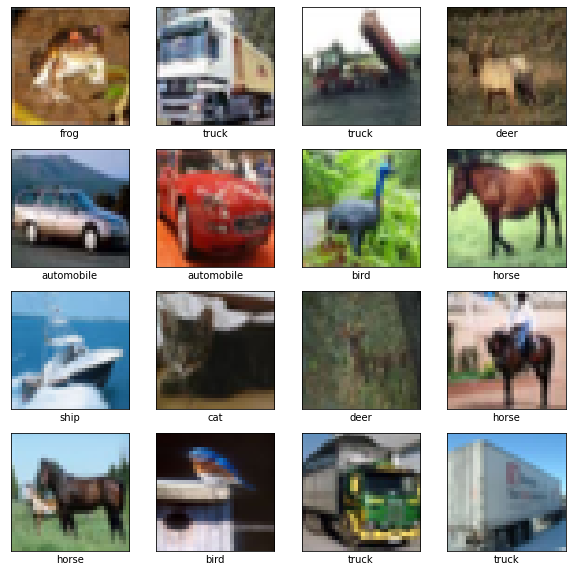

In [24]:
#  sample images from X_train
plt.figure(figsize = (10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(X_train[i], cmap = plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])  

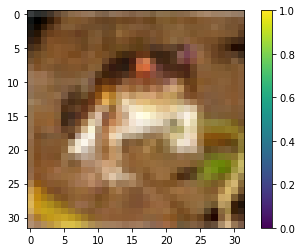

In [25]:
# vizualize the pixle range for the first image from the training dataset to
plt.figure()
plt.imshow(X_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

* **Our dataset has a normalized pixel as expected.**

In [26]:
# One-hot Encoding Targets, i.e., Change y_train to categorical
y_train =to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test =to_categorical(y_test)

In [27]:
# check size

y_train.shape

(49000, 10)

In [28]:
y_valid.shape

(1000, 10)

In [29]:

# Check y_train.
y_train[0:10]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [30]:
# let's assign: 
num_classes = y_train.shape[1]
num_classes

10

In [31]:
print(X_test.shape)
print(y_test.shape)

(10000, 32, 32, 3)
(10000, 10)


NNs are invented to imitate how neurons in human brain work:


<div>
<img src="images/cv15-16.png" width="1000"/> 
<div> 


Fig. `Building Artificial NNs` - picture source (Mohammed 9)

## ANN and CNN Models



In [32]:
# Build simple artificial neural network 
from tensorflow.keras import datasets, layers, models

ann = models.Sequential([
        layers.Flatten(input_shape=(32,32,3)),
        layers.Dense(3000, activation='relu'),
        layers.Dense(1000, activation='relu'),
        layers.Dense(10, activation='softmax')    
    ])

ann.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



You can see that at the end of 10 epochs, accuracy is at around 54%

In [33]:

ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 3000)              9219000   
                                                                 
 dense_1 (Dense)             (None, 1000)              3001000   
                                                                 
 dense_2 (Dense)             (None, 10)                10010     
                                                                 
Total params: 12,230,010
Trainable params: 12,230,010
Non-trainable params: 0
_________________________________________________________________


In [34]:
history_a =ann.fit( X_train, y_train,epochs=10,validation_data=(X_valid, y_valid), batch_size=None)


Epoch 1/10
1532/1532 [==============================] - 61s 40ms/step - loss: 1.8152 - accuracy: 0.3535 - val_loss: 227.0696 - val_accuracy: 0.3190
Epoch 2/10
1532/1532 [==============================] - 63s 41ms/step - loss: 1.6277 - accuracy: 0.4259 - val_loss: 233.4443 - val_accuracy: 0.3880
Epoch 3/10
1532/1532 [==============================] - 61s 40ms/step - loss: 1.5477 - accuracy: 0.4524 - val_loss: 178.7669 - val_accuracy: 0.4420
Epoch 4/10
1532/1532 [==============================] - 61s 40ms/step - loss: 1.4889 - accuracy: 0.4765 - val_loss: 155.9141 - val_accuracy: 0.4670
Epoch 5/10
1532/1532 [==============================] - 61s 40ms/step - loss: 1.4387 - accuracy: 0.4926 - val_loss: 185.3306 - val_accuracy: 0.4640
Epoch 6/10
1532/1532 [==============================] - 62s 41ms/step - loss: 1.3964 - accuracy: 0.5089 - val_loss: 192.0330 - val_accuracy: 0.4470
Epoch 7/10
1532/1532 [==============================] - 62s 40ms/step - loss: 1.3584 - accuracy: 0.5217 - val_lo

In [35]:
# training accuracy
history_a.history['accuracy'][-1], history_a.history['val_accuracy'][-1]


(0.5590816140174866, 0.42899999022483826)

In [36]:
# testing
evaluation = ann.evaluate(X_test, y_test)
print(f'Test Accuracy: {round(evaluation[1]*100, 4)}%')

313/313 [==============================] - 2s 6ms/step - loss: 1.3945 - accuracy: 0.5060
Test Accuracy: 50.6%


### Convolutional layers

In [24]:
# Now let us build a convolutional neural network to train our images

cnn = models.Sequential([
    # first convolutional layer
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    
    # second convolutional layer
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # fully connected classifier
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax') # 10 outputs/classes
])          # softmax activation is used since we are dealing with categorical distribution

In [25]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2304)              0         
                                                                 
 dense_3 (Dense)             (None, 256)              

Before we proceed to `compile` the model, let's visualize the 3 category of layers we just created. Let's break down the following picture into our layers:


<div>
<img src="images/cv13.png" width="600"/> 
<div> 


Fig.19:Source - [Top 9 Machine Learning Algorithms to Use for SEO & Marketing](https://online.datasciencedojo.com/blogs/top-9-machine-learning-algorithms-to-use-for-seo-marketing?utm_content=195033979&utm_medium=social&utm_source=linkedin&hss_channel=lcp-3740012)

**Here are the breakdown of `fig.19` into the three layers:**

<div>
<img src="images/cv10.png" width="600"/> 
<div> 

Fig.20-a: for the first convolutional layer

<div>
<img src="images/cv11.png" width="600"/> 
<div> 
    
Fig.20-b: for thesecond convolutional layer

<div>
<img src="images/cv12.png" width="600"/> 
<div> 
    
Fig.20-c: for the fully connected classifier


Fig.20 picture source: [Convolutional Neural Networks](https://www.youtube.com/watch?v=AjtX1N_VT9E)

<div>
<img src="img/cnn14.png" width="600"/> 
<div>
    

Fig.21 Source:[Convolutional Neural Networks for Visual recognition](https://cs231n.github.io/convolutional-networks/#conv/)

In [26]:
# compile the model
cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
history1=cnn.fit( X_train, y_train,epochs=10,validation_data=(X_valid, y_valid), batch_size=None)


Epoch 1/10
938/938 [==============================] - 17s 17ms/step - loss: 1.5085 - accuracy: 0.4566 - val_loss: 1.3206 - val_accuracy: 0.5282
Epoch 2/10
938/938 [==============================] - 16s 17ms/step - loss: 1.1329 - accuracy: 0.6007 - val_loss: 1.1523 - val_accuracy: 0.5976
Epoch 3/10
938/938 [==============================] - 16s 17ms/step - loss: 0.9644 - accuracy: 0.6633 - val_loss: 1.0148 - val_accuracy: 0.6482
Epoch 4/10
938/938 [==============================] - 16s 17ms/step - loss: 0.8473 - accuracy: 0.7042 - val_loss: 0.9706 - val_accuracy: 0.6656
Epoch 5/10
938/938 [==============================] - 16s 17ms/step - loss: 0.7338 - accuracy: 0.7449 - val_loss: 0.9652 - val_accuracy: 0.6726
Epoch 6/10
938/938 [==============================] - 16s 17ms/step - loss: 0.6289 - accuracy: 0.7809 - val_loss: 0.9663 - val_accuracy: 0.6771
Epoch 7/10
938/938 [==============================] - 16s 17ms/step - loss: 0.5232 - accuracy: 0.8204 - val_loss: 1.0205 - val_accuracy:

With CNN, at the end 5 epochs, accuracy was at around 67% which is a significant improvement over ANN.<br> CNN's are best for image classification and gives superb accuracy. Also computation is much less compared to simple ANN as maxpooling reduces the image dimensions while still preserving the features.



In [28]:
cnn.evaluate(X_test,y_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.2520 - accuracy: 0.6713


[1.2520023584365845, 0.6712999939918518]

In [29]:
y_pred = cnn.predict(X_test)
y_pred[:5]

array([[4.0596132e-03, 1.0336905e-03, 1.4397630e-03, 8.9105570e-01,
        3.3925031e-03, 8.8999026e-02, 2.9053877e-04, 1.9820205e-04,
        6.0536969e-03, 3.4772656e-03],
       [3.5754414e-04, 4.9268987e-02, 2.2431984e-13, 1.4528527e-09,
        1.8984166e-15, 6.5378020e-13, 1.6786199e-14, 6.7853201e-14,
        9.5027483e-01, 9.8654753e-05],
       [2.0479739e-01, 5.3312086e-02, 6.6128312e-05, 4.9033808e-04,
        3.0007728e-05, 2.8366021e-05, 6.0342836e-07, 2.5901605e-05,
        7.0414650e-01, 3.7102658e-02],
       [9.8053062e-01, 8.8548586e-03, 6.6113891e-05, 3.0645962e-05,
        1.4348865e-07, 4.6881027e-08, 9.0703868e-11, 7.8063206e-10,
        8.6888913e-03, 1.8287434e-03],
       [4.9945370e-10, 1.8162481e-06, 4.5660784e-04, 1.6889224e-02,
        9.7353441e-01, 7.2866103e-05, 9.0448847e-03, 5.3619984e-09,
        1.2037013e-07, 1.1769181e-07]], dtype=float32)

In [30]:
y_classes = [np.argmax(element) for element in y_pred]
y_classes[:5]

[3, 8, 8, 0, 4]

In [31]:
class_names[y_classes[3]]

'airplane'

In [32]:
y_test[:5]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [33]:
# training accuracy
history1.history['accuracy'][-1], history1.history['val_accuracy'][-1]


(0.9128999710083008, 0.676800012588501)

In [36]:
# testing
evaluation = cnn.evaluate(X_test, y_test)
print(f'Test Accuracy: {round(evaluation[1]*100, 4)}%')

313/313 [==============================] - 1s 4ms/step - loss: 1.2520 - accuracy: 0.6713
Test Accuracy: 67.13%


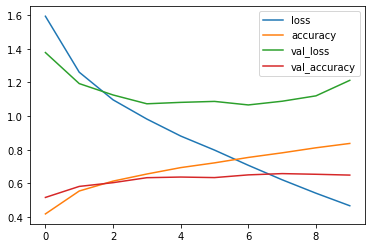

In [36]:
pd.DataFrame(history1.history).plot();

 ### 91% training accuracy and 67% `Testing` accuracy; overfitting. i.e., our model performs good on the training data set but fails to generalize on the unseen data (or testing data). <br>
I'm going to apply some regularizations to cobat the **over fitting**:
## Regularization 1: DropOut <br>

>In dropout regularization, we randomly drop units (nodes) in our neural network during our training phase only. We assign a probability of each node disappearing. Then, we essentially perform a coinflip for every node to turn that node "on" or "off." <br>
Let's go through an example to illustrate this: For simplicity, we'll say we've assigned a 0.5 probability of keeping to every node in the network above. Then, for every node, we flip a coin, and if the coin lands on heads, the node remains, if it lands on tails, the node disappears.

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/04/1IrdJ5PghD9YoOyVAQ73MJw.gif)


Fig.22 Source (DSIR-111 classnote)

So, what does this do?<br>
The intuition behind dropout is that, since each node has a probability of disappearing at any time, the neural network is disincentivized from allocating too much power to any one weight. It has a similar effect as imposing an L2 penalty: the magnitude of our weights shrinks.


Read more on [Understanding Dropout with the Simplified Math behind it](https://towardsdatascience.com/simplified-math-behind-dropout-in-deep-learning-6d50f3f47275)

- Source:[ClassNote](https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/)<br>Drop out literally means we gonna drop some of the neural units randomly from our network, which forces the next layer to learn the patterns again. In this way our model will become more robust and generalizes well. Lets try to add drop out after each CNN layer + MaxPool Layer.

## Model 2 : Add Drop out

In [57]:
model2=Sequential()
model2.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(32,32,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.25)) # Drop 25% of the units from the layer.
model2.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(32,32,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(256,activation='relu'))
model2.add(Dense(10,activation='softmax'))
model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

history2=model2.fit(X_train,y_train,epochs=20,validation_data=(X_valid,y_valid))

Epoch 1/20
938/938 [==============================] - 15s 16ms/step - loss: 1.5968 - accuracy: 0.4239 - val_loss: 1.3222 - val_accuracy: 0.5322
Epoch 2/20
938/938 [==============================] - 14s 15ms/step - loss: 1.2715 - accuracy: 0.5457 - val_loss: 1.1967 - val_accuracy: 0.5807
Epoch 3/20
938/938 [==============================] - 14s 15ms/step - loss: 1.1378 - accuracy: 0.5963 - val_loss: 1.0977 - val_accuracy: 0.6140
Epoch 4/20
938/938 [==============================] - 14s 15ms/step - loss: 1.0492 - accuracy: 0.6310 - val_loss: 1.0311 - val_accuracy: 0.6430
Epoch 5/20
938/938 [==============================] - 14s 15ms/step - loss: 0.9742 - accuracy: 0.6583 - val_loss: 0.9792 - val_accuracy: 0.6686
Epoch 6/20
938/938 [==============================] - 14s 15ms/step - loss: 0.8947 - accuracy: 0.6856 - val_loss: 0.9722 - val_accuracy: 0.6651
Epoch 7/20
938/938 [==============================] - 14s 15ms/step - loss: 0.8401 - accuracy: 0.7026 - val_loss: 0.9302 - val_accuracy:

In [58]:
# training accuracy
history2.history['accuracy'][-1], history2.history['val_accuracy'][-1]

(0.8572999835014343, 0.6863499879837036)

In [59]:
evaluation = model2.evaluate(X_test, y_test)
print('Test Accuracy: {}'.format(evaluation[1]))

313/313 [==============================] - 1s 3ms/step - loss: 1.1192 - accuracy: 0.6798
Test Accuracy: 0.6797999739646912


<AxesSubplot:>

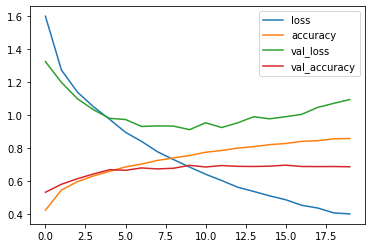

In [60]:
pd.DataFrame(history2.history).plot()

- ## Testing score went up from 65.3% to 67.98%; good improvement

## Model 3 : Add More layers with more filters.

In [62]:
model3 = Sequential()
model3.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', input_shape = (32,32,3)))
model3.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model3.add(MaxPooling2D(2,2))
model3.add(Dropout(0.4))


model3.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'))
model3.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'))
model3.add(MaxPooling2D(2,2))
model3.add(Dropout(0.4))

model3.add(Flatten())

model3.add(Dense(units = 1024, activation = 'relu'))

model3.add(Dense(units = 1024, activation = 'relu'))

model3.add(Dense(units = 10, activation = 'softmax'))
model3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
# model3.fit_generator(train_generator,epochs=100,steps_per_epoch=training_steps,validation_data=test_generator,validation_steps=validation_steps,callbacks=[board])
history3=model3.fit(X_train,y_train,epochs=50,validation_data=(X_valid,y_valid)) # Train for more number of epochs, 100

Epoch 1/50
938/938 [==============================] - 108s 115ms/step - loss: 1.7102 - accuracy: 0.3602 - val_loss: 1.4079 - val_accuracy: 0.4854
Epoch 2/50
938/938 [==============================] - 109s 116ms/step - loss: 1.3752 - accuracy: 0.4972 - val_loss: 1.2216 - val_accuracy: 0.5534
Epoch 3/50
938/938 [==============================] - 110s 117ms/step - loss: 1.2354 - accuracy: 0.5524 - val_loss: 1.1786 - val_accuracy: 0.5697
Epoch 4/50
938/938 [==============================] - 106s 113ms/step - loss: 1.1205 - accuracy: 0.5993 - val_loss: 1.0525 - val_accuracy: 0.6278
Epoch 5/50
938/938 [==============================] - 106s 114ms/step - loss: 1.0316 - accuracy: 0.6322 - val_loss: 0.9715 - val_accuracy: 0.6564
Epoch 6/50
938/938 [==============================] - 109s 116ms/step - loss: 0.9577 - accuracy: 0.6573 - val_loss: 0.9351 - val_accuracy: 0.6708
Epoch 7/50
938/938 [==============================] - 107s 114ms/step - loss: 0.8922 - accuracy: 0.6831 - val_loss: 0.9109 -

In [63]:
# training accuracy
history3.history['accuracy'][-1], history3.history['val_accuracy'][-1]

(0.9298999905586243, 0.7376999855041504)

In [64]:
evaluation = model3.evaluate(X_test, y_test)
print('Test Accuracy: {}'.format(evaluation[1]))

313/313 [==============================] - 5s 17ms/step - loss: 1.3762 - accuracy: 0.7360
Test Accuracy: 0.7360000014305115


<AxesSubplot:>

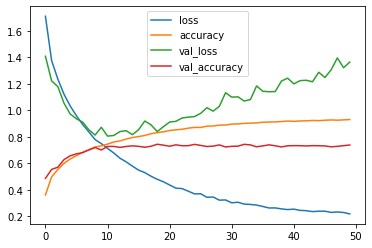

In [65]:
pd.DataFrame(history3.history).plot()

Adding more layers and increasing droup out from 0.25 to 0.4 resulted in 73.6 % accuracy which is a huge improvement, so lets try increase layers. Also don't just blindly add more layers. If you keep adding more CNN's we will lose the data as data will be reduced in size due to convolution. So when we use small size images its good idea to limit the number of layers ([source](https://www.kaggle.com/kedarsai/cifar-10-88-accuracy-using-keras)).



## Model 4: Increased layers and Filters along with Increased dropout

In [66]:
model4 = Sequential()
model4.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model4.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model4.add(MaxPooling2D((2, 2)))
model4.add(Dropout(0.2))
model4.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model4.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model4.add(MaxPooling2D((2, 2)))
model4.add(Dropout(0.3))
model4.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model4.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model4.add(MaxPooling2D((2, 2)))
model4.add(Dropout(0.4))
model4.add(Flatten())
model4.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model4.add(Dropout(0.5))
model4.add(Dense(10, activation='softmax'))
# compile model
# opt = SGD(lr=0.001, momentum=0.9)
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model4.fit_generator(train_generator,epochs=100,steps_per_epoch=training_steps,validation_data=test_generator,validation_steps=validation_steps,callbacks=[board])
history4=model4.fit(X_train,y_train,epochs=50,validation_data=(X_valid,y_valid))

Epoch 1/50
938/938 [==============================] - 80s 84ms/step - loss: 1.8700 - accuracy: 0.2970 - val_loss: 1.5130 - val_accuracy: 0.4460
Epoch 2/50
938/938 [==============================] - 79s 84ms/step - loss: 1.4800 - accuracy: 0.4638 - val_loss: 1.2342 - val_accuracy: 0.5430
Epoch 3/50
938/938 [==============================] - 76s 81ms/step - loss: 1.2926 - accuracy: 0.5373 - val_loss: 1.1446 - val_accuracy: 0.5888
Epoch 4/50
938/938 [==============================] - 79s 84ms/step - loss: 1.1875 - accuracy: 0.5790 - val_loss: 1.0494 - val_accuracy: 0.6309
Epoch 5/50
938/938 [==============================] - 77s 82ms/step - loss: 1.1090 - accuracy: 0.6123 - val_loss: 0.9982 - val_accuracy: 0.6449
Epoch 6/50
938/938 [==============================] - 80s 86ms/step - loss: 1.0404 - accuracy: 0.6328 - val_loss: 0.9209 - val_accuracy: 0.6761
Epoch 7/50
938/938 [==============================] - 77s 82ms/step - loss: 0.9977 - accuracy: 0.6518 - val_loss: 0.8965 - val_accuracy:

In [67]:
# training accuracy
history4.history['accuracy'][-1], history4.history['val_accuracy'][-1]

(0.8014666438102722, 0.7806500196456909)

In [68]:
evaluation = model4.evaluate(X_test, y_test)
print('Test Accuracy: {}'.format(evaluation[1]))

313/313 [==============================] - 4s 13ms/step - loss: 0.7010 - accuracy: 0.7788
Test Accuracy: 0.7788000106811523


<AxesSubplot:>

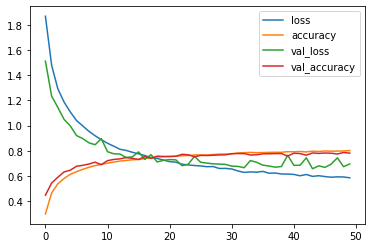

In [69]:
pd.DataFrame(history4.history).plot()

## Model 5: Adding Batch Normalization
>Batch normalization works just the same way as we normalize the input data where we divided the x_train/255. What we are trying to do there is we are arranging all the features in same scale so that model converges easily and we can reduce the distrotions. Our input layer is lucky enough to have everything in same scale why not the rest of the layers? <br>
This is what exactly we do in batch normalization, when ever we passs the CNN throuh a batch normalization layer we are normalizing the weights so that our model will be stable and we can train model longer and also use larger learning rate.<br>
Also the kind of normalization we use is batch normalization which means we compute mean and varience for each mini batch not the whole data. <br>


In [71]:
model5 = Sequential()
model5.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model5.add(BatchNormalization())
model5.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D((2, 2)))
model5.add(Dropout(0.2))
model5.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model5.add(BatchNormalization())
model5.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D((2, 2)))
model5.add(Dropout(0.3))
model5.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model5.add(BatchNormalization())
model5.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D((2, 2)))
model5.add(Dropout(0.4))
model5.add(Flatten())
model5.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model5.add(BatchNormalization())
model5.add(Dropout(0.5))
model5.add(Dense(10, activation='softmax'))
# compile model
# opt = SGD(lr=0.001, momentum=0.9)
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model5.fit_generator(train_generator,epochs=200,steps_per_epoch=training_steps,validation_data=test_generator,validation_steps=validation_steps,callbacks=[board])
history5=model5.fit(X_train,y_train,epochs=50,validation_data=(X_valid,y_valid))

Epoch 1/50
938/938 [==============================] - 103s 109ms/step - loss: 1.7995 - accuracy: 0.3873 - val_loss: 1.2916 - val_accuracy: 0.5264
Epoch 2/50
938/938 [==============================] - 106s 113ms/step - loss: 1.2400 - accuracy: 0.5584 - val_loss: 0.9981 - val_accuracy: 0.6447
Epoch 3/50
938/938 [==============================] - 96s 102ms/step - loss: 1.0646 - accuracy: 0.6246 - val_loss: 0.9216 - val_accuracy: 0.6683
Epoch 4/50
938/938 [==============================] - 96s 102ms/step - loss: 0.9488 - accuracy: 0.6676 - val_loss: 0.8197 - val_accuracy: 0.7111
Epoch 5/50
938/938 [==============================] - 96s 102ms/step - loss: 0.8722 - accuracy: 0.6973 - val_loss: 0.7560 - val_accuracy: 0.7319
Epoch 6/50
938/938 [==============================] - 95s 102ms/step - loss: 0.8099 - accuracy: 0.7180 - val_loss: 0.7433 - val_accuracy: 0.7434
Epoch 7/50
938/938 [==============================] - 96s 102ms/step - loss: 0.7426 - accuracy: 0.7439 - val_loss: 0.6945 - val_

In [73]:
# training accuracy
history5.history['accuracy'][-1], history5.history['val_accuracy'][-1]

(0.9268333315849304, 0.8363000154495239)

In [74]:
evaluation = model5.evaluate(X_test, y_test)
print('Test Accuracy: {}'.format(evaluation[1]))

313/313 [==============================] - 5s 15ms/step - loss: 0.5823 - accuracy: 0.8348
Test Accuracy: 0.8348000049591064


<AxesSubplot:>

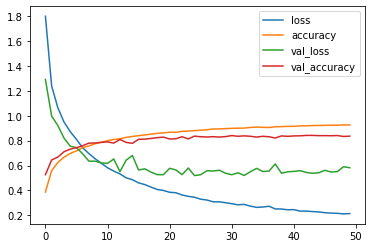

In [75]:
pd.DataFrame(history5.history).plot();

>Adding batch normalizaton yeilds very good results and we are able to get 87.3% validation accuracy. Which is really good. Batch normalization made our average results into excellent results. Still there is a lot of improvement scope. I just refered to Benchmarks.ai website and I was shocked to see 99.37. So there is defnelty a lot we can do.

## Model 6: Image augmentation
We already have 60K images and we can generate lots and lots of images out of it <br>


>See from just one image we now genearated 6 images just by changing the inclanation of the subject. Ofcourse it might looks same image for our eyes but for machine it is a different image, since the pixel values changes. We can play with color of the image, focus of the image, shift of the image etc. Image augmentation really helps machine to understand that a cat is a cat, irrespective of the color or image position. <br>
To augmet the data we are using the ImageDataGenerator of tensorflow keras preprocessing library.
[source](https://www.kaggle.com/kedarsai/cifar-10-88-accuracy-using-keras)<


Also the article, [Regularization in Deep Learning — L1, L2, and Dropout](https://towardsdatascience.com/regularization-in-deep-learning-l1-l2-and-dropout-377e75acc036), has more details on $L_1$ and $L_2$ regularizations as well.

In [78]:
model6 = Sequential()
model6.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model6.add(BatchNormalization())
model6.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model6.add(BatchNormalization())
model6.add(MaxPooling2D((2, 2)))
model6.add(Dropout(0.2))
model6.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model6.add(BatchNormalization())
model6.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model6.add(BatchNormalization())
model6.add(MaxPooling2D((2, 2)))
model6.add(Dropout(0.3))
model6.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model6.add(BatchNormalization())
model6.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model6.add(BatchNormalization())
model6.add(MaxPooling2D((2, 2)))
model6.add(Dropout(0.4))
model6.add(Flatten())
model6.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model6.add(BatchNormalization())
model6.add(Dropout(0.5))
model6.add(Dense(10, activation='softmax'))
# compile model
# opt = SGD(lr=0.001, momentum=0.9)
model6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Image Data Generator , we are shifting image accross width and height also we are flipping the image horizantally.
datagen = ImageDataGenerator(width_shift_range=0.1, 
                             height_shift_range=0.1, 
                             horizontal_flip=True,
                             rotation_range=20)

it_train = datagen.flow(X_train,y_train)
steps = int(X_train.shape[0] / 64)
history6=model6.fit(it_train,epochs=200,steps_per_epoch=steps,validation_data=(X_valid,y_valid))


Epoch 1/200
468/468 [==============================] - 52s 111ms/step - loss: 2.1524 - accuracy: 0.3001 - val_loss: 1.6569 - val_accuracy: 0.4051
Epoch 2/200
468/468 [==============================] - 52s 112ms/step - loss: 1.6365 - accuracy: 0.4121 - val_loss: 1.5503 - val_accuracy: 0.4679
Epoch 3/200
468/468 [==============================] - 52s 111ms/step - loss: 1.4665 - accuracy: 0.4675 - val_loss: 1.2626 - val_accuracy: 0.5526
Epoch 4/200
468/468 [==============================] - 52s 111ms/step - loss: 1.3287 - accuracy: 0.5212 - val_loss: 1.2035 - val_accuracy: 0.5658
Epoch 5/200
468/468 [==============================] - 53s 113ms/step - loss: 1.2538 - accuracy: 0.5528 - val_loss: 1.2692 - val_accuracy: 0.5658
Epoch 6/200
468/468 [==============================] - 52s 112ms/step - loss: 1.2028 - accuracy: 0.5766 - val_loss: 1.1209 - val_accuracy: 0.6209
Epoch 7/200
468/468 [==============================] - 52s 112ms/step - loss: 1.1384 - accuracy: 0.6000 - val_loss: 1.0943 -

In [79]:
# training accuracy
history6.history['accuracy'][-1], history6.history['val_accuracy'][-1]

(0.8603609800338745, 0.870199978351593)

In [80]:
evaluation = model6.evaluate(X_test, y_test)
print('Test Accuracy: {}'.format(evaluation[1]))

313/313 [==============================] - 6s 16ms/step - loss: 0.4004 - accuracy: 0.8696
Test Accuracy: 0.8695999979972839


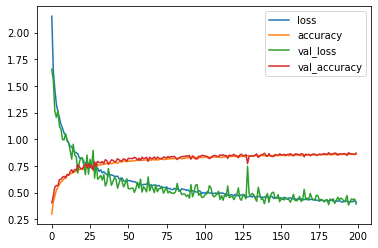

In [81]:
pd.DataFrame(history6.history).plot();

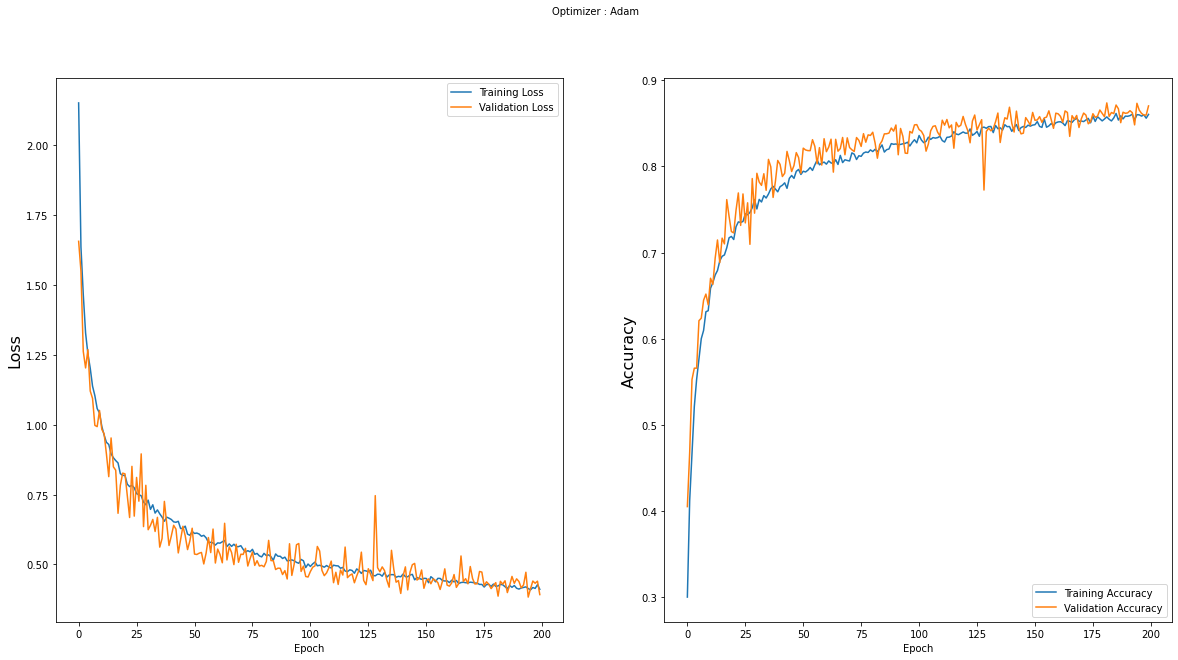

In [85]:
# plot the evolution of Loss and Acuracy on the train and validation sets

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch')
plt.plot(history6.history['loss'], label='Training Loss')
plt.plot(history6.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epoch')
plt.plot(history6.history['accuracy'], label='Training Accuracy')
plt.plot(history6.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show();


313/313 - 5s - loss: 0.4004 - accuracy: 0.8696 - 5s/epoch - 16ms/step


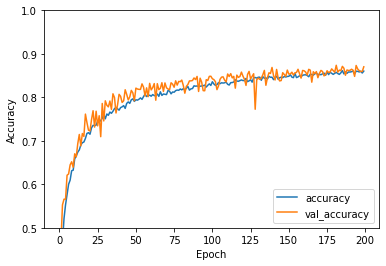

In [83]:
plt.plot(history6.history['accuracy'], label='accuracy')
plt.plot(history6.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model6.evaluate(X_test,  y_test, verbose=2)

## Save the `Best` Model

In [127]:
# saving our model
model6.save("models/bestModel.h5")

In [38]:
model = keras.models.load_model('models/bestModel.h5')


In [39]:
# evaluate test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print(f'Test accuracy is:{round(accuracy,4)}%' )


Test accuracy is:86.96%


In [48]:
# evaluation = model.evaluate(X_test, y_test)
# print(f'Test Accuracy: {round(evaluation[1],2)*100}%')

# Final Result
My `best model`, which has `86% accuracy on training` and `87% accuracy on validation` datasets, has `87% accurate on testing`. Just sticking to this `best model` of mine for now, I will make sample predictions on Testing dataset which has 10,000 images. The prediction shows the labels of the images in green color if correctely classified, and in `red color` if it fails. <br>


In [40]:
# get predictions on the test set
y_hat = model.predict(X_test)


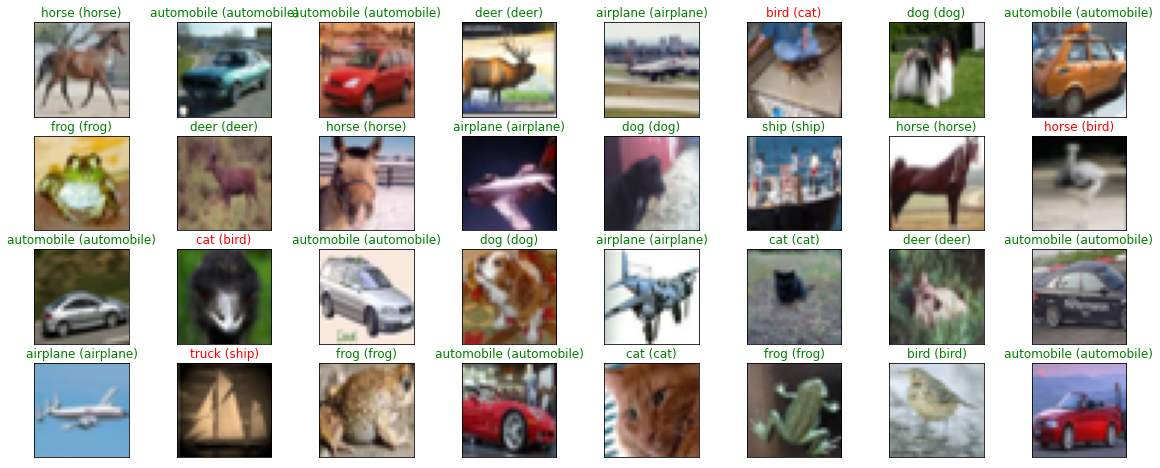

In [41]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(class_names[pred_idx], class_names[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))
    
    # code from: https://github.com/moelgendy/deep_learning_for_vision_systems/blob/master/chapter_03/chapter_3_cifar10_cnn.ipynb

In [42]:
y_true = np.argmax(y_test, axis=1)
y_true

array([3, 8, 8, ..., 5, 1, 7])

In [43]:
y_pred_class= np.argmax(y_hat, axis=1) 
y_pred_class

array([3, 8, 8, ..., 5, 1, 7])

In [44]:
# checking misclassification
incorrect_pred_idx=np.where(y_true!=y_pred_class)[0].tolist()
len(incorrect_pred_idx)

1304

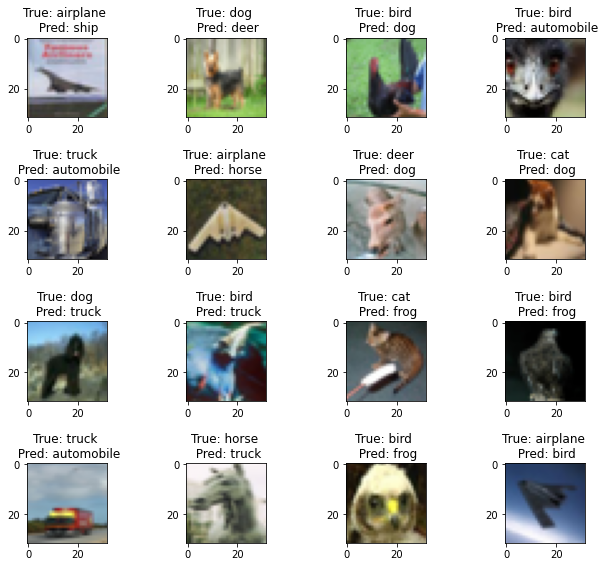

In [45]:
# sample images that are misclassified
fig,axes=plt.subplots(4,4,figsize=(10,10))
axes=axes.ravel()

for i in np.arange(0,16):
        axes[i].imshow(X_test[incorrect_pred_idx[i]])
        axes[i].set_title('True: %s \n Pred: %s'%(class_names[y_true[incorrect_pred_idx[i]]],class_names[y_pred_class[incorrect_pred_idx[i]]]))
        plt.subplots_adjust(wspace=1)

313/313 - 4s - 4s/epoch - 14ms/step


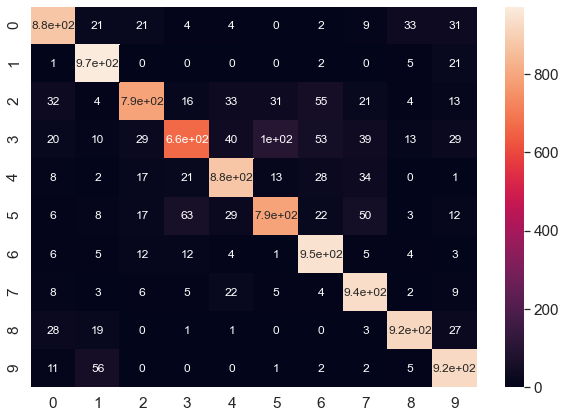

In [46]:
# Confusion matrix result

from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(X_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)

# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd


df_cm = pd.DataFrame(cm, range(10),
                  range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()

In [123]:
for i in enumerate(class_names):
    print(i)

(0, 'airplane')
(1, 'automobile')
(2, 'bird')
(3, 'cat')
(4, 'deer')
(5, 'dog')
(6, 'frog')
(7, 'horse')
(8, 'ship')
(9, 'truck')


---

---

References:
- E.Mohammed, Deep Learning for Vision Systems, Manning Publications Co, 2020.
- I. Goodfellow, Y. Bengio, A. Courville, Deep Learning, MIT Press, 2016.


**Recomended readings:**

* [Convolutional Neural Network (CNN)](https://www.tensorflow.org/tutorials/images/cnn)
* [Starting with cnn](https://www.kaggle.com/pg1007/starting-with-cnn)
* [cifar10 with CNN for beginer](https://www.kaggle.com/roblexnana/cifar10-with-cnn-for-beginer)
* [CIFAR 10 88% Accuracy using Keras](https://www.kaggle.com/kedarsai/cifar-10-88-accuracy-using-keras)
* [CIFAR-10 object classification Best model](https://www.kaggle.com/faizanurrahmann/cifar-10-object-classification-best-model)
* [Introduction to CNN Keras - 0.997 (top 6%)](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6)
* [Convolutional Neural Network (CNN) Tutorial](https://www.kaggle.com/kanncaa1/convolutional-neural-network-cnn-tutorial)
* [Python | Image Classification using Keras](https://www.geeksforgeeks.org/python-image-classification-using-keras/) from **GeeksforGeeks**
* [Image classification from scratch in keras.Image classification from scratch in keras.](https://towardsdatascience.com/image-detection-from-scratch-in-keras-f314872006c9https://towardsdatascience.com/image-detection-from-scratch-in-keras-f314872006c9) †
* [Applied Deep Learning - Part 4: Convolutional Neural Networks](https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2)††
* [An intuitive guide to Convolutional Neural Networks](https://www.freecodecamp.org/news/an-intuitive-guide-to-convolutional-neural-networks-260c2de0a050)
* [ML Glossary Documents](https://ml-cheatsheet.readthedocs.io/en/latest/nn_concepts.html)* [Starting with cnn](https://www.kaggle.com/pg1007/starting-with-cnn)
* [cifar10 with CNN for beginer](https://www.kaggle.com/roblexnana/cifar10-with-cnn-for-beginer)
* [CIFAR 10 88% Accuracy using Keras](https://www.kaggle.com/kedarsai/cifar-10-88-accuracy-using-keras)
* [CIFAR-10 object classification Best model](https://www.kaggle.com/faizanurrahmann/cifar-10-object-classification-best-model)
* [Introduction to CNN Keras - 0.997 (top 6%)](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6)
* [Convolutional Neural Network (CNN) Tutorial](https://www.kaggle.com/kanncaa1/convolutional-neural-network-cnn-tutorial)
* [Image classification from scratch in keras.Image classification from scratch in keras.](https://towardsdatascience.com/image-detection-from-scratch-in-keras-f314872006c9https://towardsdatascience.com/image-detection-from-scratch-in-keras-f314872006c9) †
* [Applied Deep Learning - Part 4: Convolutional Neural Networks](https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2)††
* [An intuitive guide to Convolutional Neural Networks](https://www.freecodecamp.org/news/an-intuitive-guide-to-convolutional-neural-networks-260c2de0a050)
* [ML Glossary Documents](https://ml-cheatsheet.readthedocs.io/en/latest/nn_concepts.html)